In [1]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# Airplanes

- Data import
- Data inspection and cleaning
- Visualisation

## Data import

Import as pandas `dataframe` the weather report and the flights data.

In [2]:
flights_name = "../data/flights_small.csv"
# flights_name = "../data/flights_medium.csv"
# flights_name = "../data/flights_large.csv"
flights = pd.read_csv(flights_name)

In [3]:
# weather_name = "../data/weather.csv"
# weather = pd.read_csv(weather_name)

## Data inspection, cleaning, and augmentation

Inspect `flights` `dataframe` columns content.

In [4]:
flights.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2003-04-05,EV,20366,SHV,LA,MOB,AL,1820,-10,2048,30,2018,1830,-88.24,30.69,-88.24,30.69,AL to LA,1
1,2006-04-10,YV,20378,CLT,NC,MGM,AL,1613,-10,1833,-9,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
2,2006-04-05,YV,20378,CLT,NC,MGM,AL,1615,-8,1825,-17,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
3,2006-01-12,YV,20378,CLT,NC,MGM,AL,1620,-3,1840,1,1839,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
4,2006-01-05,YV,20378,CLT,NC,MGM,AL,1614,0,1840,10,1830,1614,-86.39,32.30,-86.39,32.30,AL to NC,1


The `flights` `dataframe` has 19 columns containing information on the flight date (`YYYY-MM-DD` format), operating airline (both with a two character _string_ code and a five digits _integer_ code), departure and arrival airport codes (two characters _string_), departure and arrival state codes (two characters _string_), actual and scheduled departure time (24h _integer_ format), time delay at departure in minutes (_signed integer_; this is also calculated as `Departure_actual - Departure_schedule`, therefore a negative departure time indicates that the ariplane took off before than expected), scheduled and actual arrival time (24h _integer_ format), arrival delay (_signed integer_; this can be also be calculated as `Arrival_actual - Arrival_schedule`), longitude and latitude of the departure airport (_signed float_; there are two pairs of column with this kind of data), route (_string_ departure/arrival airport codes), and the path order (_integer_).

In [5]:
#Check if the departure location is repeated
all(flights["DC_Longitude"] == flights["Longitude"]) and all(flights["DC_Latitude"] == flights["Latitude"])

True

In [6]:
#Check if the Path_order is alway equal to 1 or 2
all(flights["Path_order"]) in [1,2]

True

In the `medium` and `small` datasets, the `Path_order` is always `1`. This is not true for the `large` dataset.
- __Q1:__ what does `Path_order` column contain?

When the `Path_order == 2`, `DC_Longitude != Longitude`; why is that?
- __Q2:__ what is the difference between `DC_Longitude` (`DC_Latitude`) and `Longitude` (`Latitude`)?

Inspect `weather` `dataframe` content.

In [7]:
# weather.head()

In [8]:
# weather.shape

There are 35M+ rows and 6 columns containing the weather report date (`YYYY-MM-DD` format), airport code (_string_), time of the day (24h _integer_ format), temperature (Farenheit degrees as _signed integer_), snow (inches?) (_float_ or `NaN`), and wind velocity magnitude (knots or m/s?).

- __Q3:__ Units for snow?
- __Q4:__ Units for wind velocity?

### Cleaning
Replace `NaN`s in the `snow` cloumn with zeroes. We assume that if there are not information about the snow, this is because there was not snow at all.

In [9]:
# weather["snow"].fillna(0.0, inplace=True)

Remove from `weather` all the rows referring to airports not in `flights`.

In [10]:
#create a list of all the airports
airports = list(set(list(set(flights["Departure_Airport"])) + list(set(flights["Arrival_airport"]))))

airport_coordinates = {}
for index, row in flights.drop_duplicates(subset=["Departure_Airport"], keep='first', inplace=False).iterrows():
    airport_coordinates[row["Departure_Airport"]] = (row["Latitude"], row["Longitude"])

#filter weather dataset
# weather_at_airports = weather[weather['airport'].isin(airports)]

In [11]:
#routes
routes = flights.drop_duplicates(subset=["Departure_Airport", "Arrival_airport"], keep="first")

In [12]:
#date to float
# flights["Date"] = pd.to_datetime(flights["Date"])
# weather["Date"] = pd.to_datetime(weather["Date"])
# dt = pd.DatetimeIndex(dt).astype ( np.int64 )/1000000

## Visualisation

Visualise the US map, the airport locations, and the flight routes.

In [13]:
#map center
lat0 = np.mean(flights["Latitude"].astype(float))
lon0 = -112.0

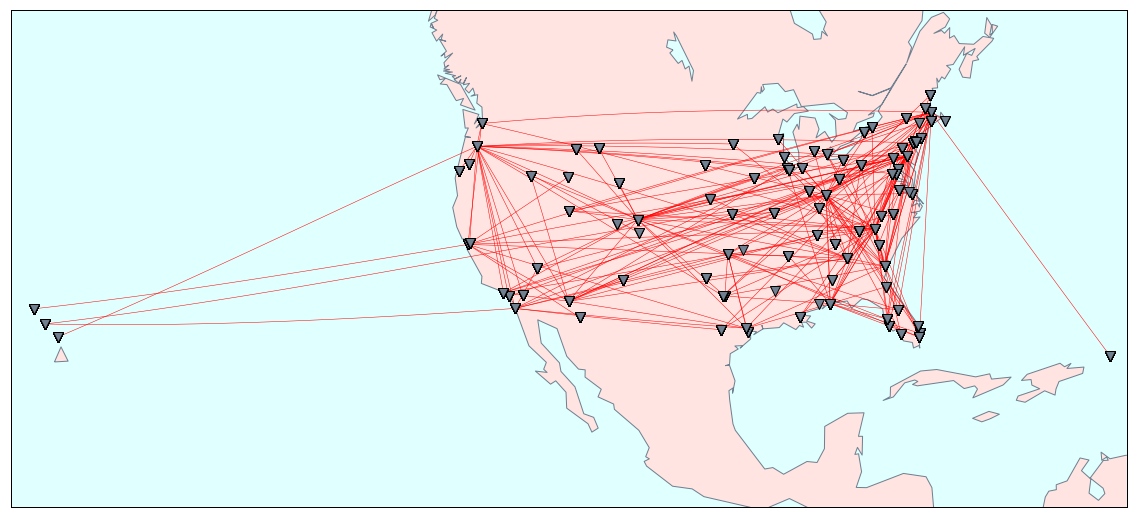

In [14]:
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)

#draw US map
m = Basemap(width=10100000,height=4500000,projection='lcc', resolution='c',lat_0=lat0, lon_0=lon0)
m.drawcoastlines(color="slategrey")
m.drawmapboundary(fill_color='lightcyan')
m.fillcontinents(color='mistyrose',lake_color='lightcyan')

# #draw airport positions
lons, lats = m(list(flights["Longitude"].astype(float)), list(flights["Latitude"].astype(float)))
m.scatter(lons, lats, s=100, marker='v', color="slategray", edgecolor='k', zorder=100, ax=ax)

#draw routes
for index, row in routes.iterrows():
    try:
        arr_airport = row["Arrival_airport"]

        dep_airport_lon = float(row["Longitude"])
        dep_airport_lat = float(row["Latitude"])

        arr_airport_lat = float(airport_coordinates[arr_airport][0])
        arr_airport_lon = float(airport_coordinates[arr_airport][1])

        m.drawgreatcircle(dep_airport_lon, dep_airport_lat,
                          arr_airport_lon, arr_airport_lat, linewidth=0.5, color='r')
    except:
        continue

Note, all the airports have at least one connection with another airport.

We may now wonder which airport is the busiest.

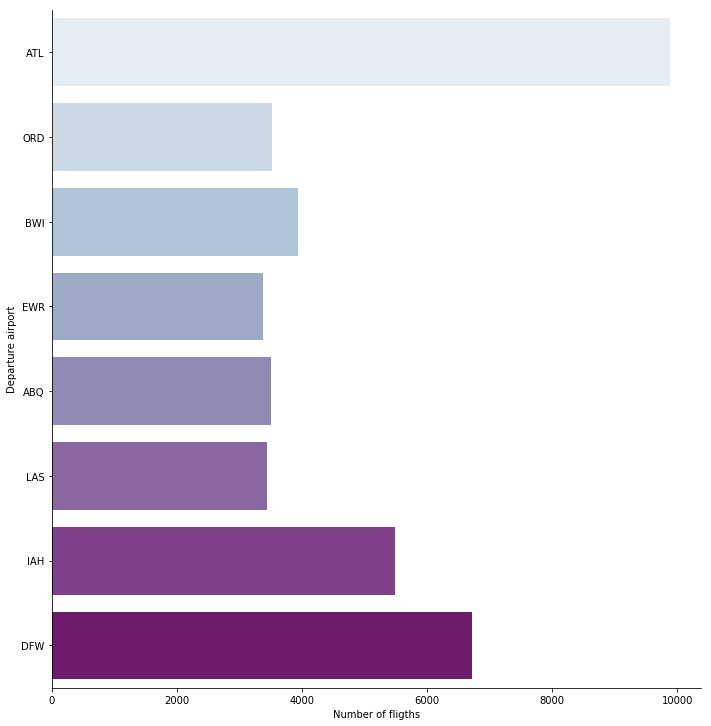

In [15]:
busiest = flights.groupby('Departure_Airport').filter(lambda x: x['Departure_Airport'].count()>3000)
g = sns.factorplot(y="Departure_Airport", data=busiest, kind="count",
                   palette="BuPu", size=10)
g.set_xlabels("Number of fligths")
g.set_ylabels("Departure airport")

Or, what is the busiest time of the day and if there are correlations between day time and travel delay.

Text(0,0.5,'Delay (minutes)')

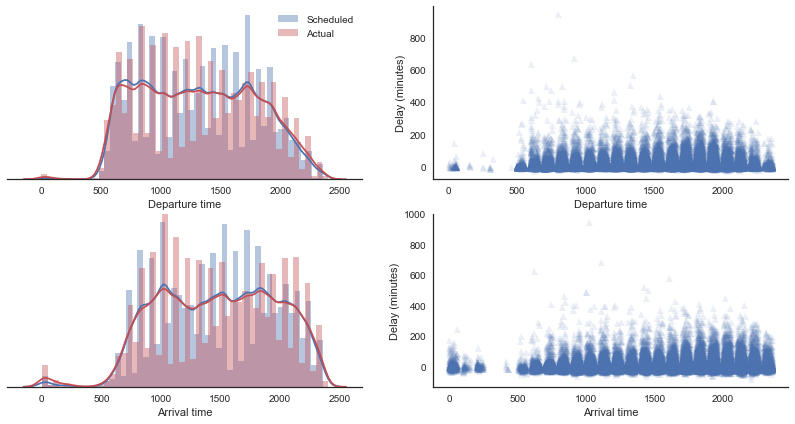

In [125]:
f, axes = plt.subplots(2,2, figsize=(14,7))

sns.distplot(flights["Departure_schedule"], color="b", label="Scheduled", ax=axes[0, 0])
sns.distplot(flights["Departure_actual"], color="r", label="Actual", ax=axes[0, 0])
axes[0,0].legend()
sns.distplot(flights["Arrival_schedule"], color="b", label="Scheduled", ax=axes[1, 0])
sns.distplot(flights["Arrival_actual"], color="r", label="Actual", ax=axes[1, 0])

sns.despine(left=True, ax=axes[0,0])
sns.despine(left=True, ax=axes[1,0])
plt.setp(axes[:,0], yticks=[])
axes[0,0].set_xlabel("Departure time")
axes[1,0].set_xlabel("Arrival time")

axes[0,1].plot(flights["Departure_schedule"], flights["Departure_delay"], '^', color="b", alpha=0.1, label="Scheduled")
axes[1,1].plot(flights["Arrival_schedule"], flights["Arrival_delay"], '^', color="b", alpha=0.1, label="Scheduled")
sns.despine(ax=axes[0,1])
sns.despine(ax=axes[1,1])
axes[0,1].set_xlabel("Departure time")
axes[1,1].set_xlabel("Arrival time")
axes[0,1].set_ylabel("Delay (minutes)")
axes[1,1].set_ylabel("Delay (minutes)")

Which is the most used airline? Which is the most visited state? And the state from which most of the flights depart?

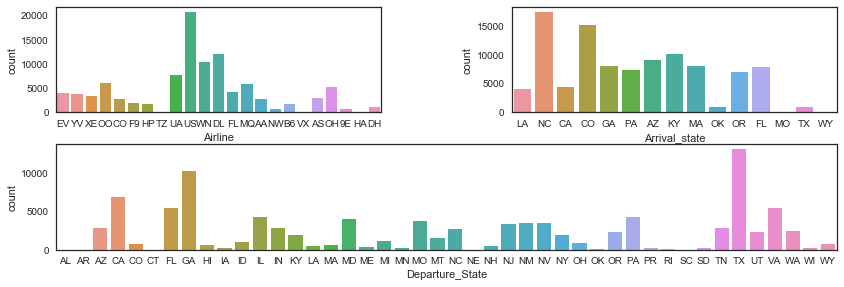

In [164]:
f = plt.figure(2, figsize=(14,7))
grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0:])
ax3 = plt.subplot(grid[0,1])
# ax4 = plt.subplot(grid[2,0:])

sns.countplot(x="Airline", data=flights, ax=ax1)
sns.countplot(x="Departure_State", data=flights, ax=ax2)
sns.countplot(x="Arrival_state", data=flights, ax=ax3)
# sns.countplot(x="Route", data=flights, ax=ax4)
